# TCN模型训练与评估

本notebook实现了基于时序卷积网络(TCN)的农作物制图模型训练、评估和推理流程。

## 1. 环境设置与导入

In [17]:
# 首先检查并设置正确的工作目录
import os
import sys

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# 获取当前工作目录
current_dir = os.getcwd()
print(f"当前工作目录: {current_dir}")

# 检查是否在正确的目录（应该包含TCN文件夹）
expected_paths = ['TCN', 'dataset', 'pyproject.toml']
missing_paths = [path for path in expected_paths if not os.path.exists(path)]

if missing_paths:
    print(f"⚠️ 当前目录缺少: {missing_paths}")
    # 尝试定位正确的项目根目录
    project_name = "DeepCropMapping"
    path_parts = current_dir.split(os.sep)
    
    if project_name in path_parts:
        # 找到项目根目录
        project_idx = path_parts.index(project_name)
        project_root = os.sep.join(path_parts[:project_idx + 1])
        
        print(f"🔍 检测到项目根目录: {project_root}")
        os.chdir(project_root)
        print(f"✅ 已切换到项目根目录: {os.getcwd()}")
    else:
        print("❌ 无法自动定位项目根目录，请手动检查工作目录")
else:
    print("✅ 工作目录正确")

# 添加项目根目录到Python路径
if os.getcwd() not in sys.path:
    sys.path.insert(0, os.getcwd())
    print(f"📂 已添加项目根目录到Python路径")

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import json
from pathlib import Path
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# 导入自定义模块
from TCN.model import create_tcn_model
from TCN.dataset import prepare_data, save_data_info
from TCN.utils import (
    save_checkpoint, 
    calculate_metrics,
    plot_training_history,
    plot_confusion_matrix,
    plot_class_performance
)
from TCN.train import FocalLoss

# 设置matplotlib中文显示
plt.rcParams['font.sans-serif'] = ['PingFang SC', 'SimHei', 'Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

print(f"\nPyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

print("\n🎉 环境设置完成，模块导入成功！")

当前工作目录: /data/coding/Deep-crop-mapping
✅ 工作目录正确

PyTorch version: 2.7.1+cu126
CUDA available: True
CUDA device: Tesla P4

🎉 环境设置完成，模块导入成功！


## 2. 模式选择与配置参数

本notebook支持两种运行模式：

### 🔧 测试模式 (test)
- **用途**: 在本地Mac快速验证代码正确性
- **特点**: 
  - 小批次大小 (batch_size=4)
  - 少训练轮数 (epochs=5)
  - 轻量化模型结构
  - 快速早停 (patience=2)
  - 使用MPS设备优化
- **适用场景**: 调试代码、验证功能、本地开发

### 🚀 训练模式 (train) 
- **用途**: 在云GPU进行完整的模型训练
- **特点**:
  - 大批次大小 (batch_size=16)
  - 完整训练轮数 (epochs=100)
  - 完整模型结构
  - 标准早停 (patience=10)
  - 优化并行处理
- **适用场景**: 正式训练、获得最佳性能、云端部署

**使用方法**: 在配置cell中修改 `MODE = 'test'` 或 `MODE = 'train'`

In [2]:
# 模式选择：'test' 或 'train'
# test: 本地Mac测试，小数据集，少轮数
# train: 云GPU训练，完整数据集，完整轮数
MODE = 'train'  # 切换为 'train' 进行完整训练

# 训练配置

# 首先，确定可用的最佳设备（GPU > MPS > CPU）
if torch.cuda.is_available():
    device = 'cuda'
# 检查macOS的MPS后端是否可用
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

# 根据模式设置基础配置
if MODE == 'test':
    # 测试模式配置 - 用于本地验证代码正确性
    base_config = {
        # 数据参数 - 使用较小的参数快速测试
        'patch_size': 32,
        'stride': 16,
        'test_size': 0.2,
        'val_size': 0.1,
        'batch_size': 4,  # 小批次
        'num_workers': 1,  # Mac上使用较少workers
        
        # 模型参数 - 使用轻量化模型
        'tcn_channels': [32, 64],  # 简化网络结构
        'kernel_size': 3,
        'dropout': 0.2,
        
        # 训练参数 - 少轮数快速验证
        'epochs': 2,  # 仅2轮测试
        'learning_rate': 1e-3,
        'weight_decay': 1e-4,
        'use_focal_loss': True,
    }
    print("🔧 Test Mode - 本地测试配置（快速验证代码）")
    
elif MODE == 'train':
    # 训练模式配置 - 优化版，针对过拟合和性能问题
    base_config = {
        # 数据参数 - 优化配置
        'patch_size': 64,  # 保持较大patch捕获空间上下文
        'stride': 32,
        'test_size': 0.2,
        'val_size': 0.1,
        'batch_size': 4,  # 减小batch_size，配合更大patch和AMP
        'num_workers': 4,  # 适中的workers
        
        # 模型参数 - 增强模型
        'tcn_channels': [96, 192, 384],  # 增加通道数提升容量
        'kernel_size': 5,  # 增大感受野
        'dropout': 0.3,  # 增加dropout防止过拟合
        
        # 训练参数 - 优化训练
        'epochs': 100,
        'learning_rate': 5e-4,  # 降低学习率
        'weight_decay': 5e-4,  # 增加weight_decay正则化
        'use_focal_loss': True,
        
        # 新增优化选项
        'focal_gamma': 2.5,  # 增加Focal Loss的gamma参数
        'label_smoothing': 0.1,  # 标签平滑
    }
    print("🚀 Train Mode - 云GPU训练配置（优化版）")
    print("📊 优化策略:")
    print("  - 降低学习率: 1e-3→5e-4 (更稳定训练)")
    print("  - 增加正则化: dropout 0.2→0.3, weight_decay 1e-4→5e-4")
    print("  - 增强模型容量: TCN通道 [64,128,256]→[96,192,384]")
    print("  - 增大感受野: kernel_size 3→5")

# 合并完整配置
config = {
    **base_config,
    # 通用参数
    'data_path': '../dataset',
    'input_channels': 8,
    'temporal_steps': 28,
    'save_dir': './checkpoints',
    'device': device,
    'mode': MODE
}

print(f"\nCurrent configuration (Mode: {MODE.upper()}):")
print("="*50)
for key, value in config.items():
    print(f"  {key}: {value}")

print(f"\nUsing device: {device}")
if MODE == 'test':
    print("⚠️  测试模式：仅用于验证代码正确性，不代表最终训练效果")
elif MODE == 'train':
    print("✅ 训练模式：优化配置，解决过拟合和性能问题")
    print("💡 建议：如果仍有显存问题，可以进一步减小batch_size到4")

# 创建保存目录
mode_save_dir = f"{config['save_dir']}_{MODE}"
config['save_dir'] = mode_save_dir
Path(config['save_dir']).mkdir(parents=True, exist_ok=True)
print(f"保存目录: {mode_save_dir}")

🚀 Train Mode - 云GPU训练配置（优化版）
📊 优化策略:
  - 降低学习率: 1e-3→5e-4 (更稳定训练)
  - 增加正则化: dropout 0.2→0.3, weight_decay 1e-4→5e-4
  - 增强模型容量: TCN通道 [64,128,256]→[96,192,384]
  - 增大感受野: kernel_size 3→5

Current configuration (Mode: TRAIN):
  patch_size: 64
  stride: 32
  test_size: 0.2
  val_size: 0.1
  batch_size: 4
  num_workers: 4
  tcn_channels: [96, 192, 384]
  kernel_size: 5
  dropout: 0.3
  epochs: 100
  learning_rate: 0.0005
  weight_decay: 0.0005
  use_focal_loss: True
  focal_gamma: 2.5
  label_smoothing: 0.1
  data_path: ../dataset
  input_channels: 8
  temporal_steps: 28
  save_dir: ./checkpoints
  device: cuda
  mode: train

Using device: cuda
✅ 训练模式：优化配置，解决过拟合和性能问题
💡 建议：如果仍有显存问题，可以进一步减小batch_size到4
保存目录: ./checkpoints_train


## 3. 数据加载与预处理

In [3]:
# 自动查找数据集路径
import os

print(f"notebook内部工作目录: {os.getcwd()}")

# 定义可能的数据集路径
possible_paths = [
    '../dataset',  # 相对于TCN目录
    './dataset',   # 当前目录下
    'dataset',     # 相对路径
    os.path.join(os.path.dirname(os.getcwd()), 'dataset'),  # 父目录的dataset
]

# 查找正确的数据集路径
dataset_path = None
for path in possible_paths:
    x_path = os.path.join(path, 'x.npy')
    y_path = os.path.join(path, 'y.npy')
    if os.path.exists(x_path) and os.path.exists(y_path):
        dataset_path = path
        print(f"✅ 找到数据集: {os.path.abspath(dataset_path)}")
        break
    else:
        print(f"❌ 路径不存在: {os.path.abspath(path)} (x.npy: {os.path.exists(x_path)}, y.npy: {os.path.exists(y_path)})")

if dataset_path is None:
    raise FileNotFoundError("未找到数据集文件 (x.npy, y.npy)")

# 更新配置
config['data_path'] = dataset_path
print(f"使用数据路径: {config['data_path']}")

# 准备数据
print("\nPreparing data loaders...")
train_loader, val_loader, test_loader, data_info = prepare_data(
    data_path=config['data_path'],
    patch_size=config['patch_size'],
    stride=config['stride'],
    test_size=config['test_size'],
    val_size=config['val_size'],
    batch_size=config['batch_size'],
    num_workers=config['num_workers']
)

# 保存数据信息
save_data_info(data_info, f"{config['save_dir']}/data_info.pkl")

print(f"Number of classes: {data_info['num_classes']}")
print(f"Class names: {data_info['class_names']}")
print(f"Train samples: {len(train_loader.dataset)}")
print(f"Validation samples: {len(val_loader.dataset)}")
print(f"Test samples: {len(test_loader.dataset)}")
print(f"Class weights: {data_info['class_weights']}")

notebook内部工作目录: /data/coding/Deep-crop-mapping
❌ 路径不存在: /data/coding/dataset (x.npy: False, y.npy: False)
✅ 找到数据集: /data/coding/Deep-crop-mapping/dataset
使用数据路径: ./dataset

Preparing data loaders...
Original data shape - X: (326, 1025, 28, 8), Y: (326, 1025)
Dataset split - Train: 195, Val: 28, Test: 56
Data info saved to ./checkpoints_train/data_info.pkl
Number of classes: 8
Class names: {1: 'Corn', 2: 'Wheat', 3: 'Sunflower', 4: 'Pumpkin', 5: 'Artificial_Surface', 6: 'Water', 7: 'Road', 8: 'Other'}
Train samples: 195
Validation samples: 28
Test samples: 56
Class weights: tensor([0.2270, 6.4004, 0.6761, 4.3405, 5.5721, 4.4759, 1.7090, 1.3487])


## 4. 创建模型

In [4]:
# 创建模型
device = torch.device(config['device'])
print(f"Using device: {device}")

model = create_tcn_model(
    input_channels=config['input_channels'],
    temporal_steps=config['temporal_steps'],
    num_classes=data_info['num_classes'],
    tcn_channels=config['tcn_channels'],
    kernel_size=config['kernel_size'],
    dropout=config['dropout']
).to(device)

# 打印模型信息
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Model created successfully!")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# 测试模型前向传播
dummy_input = torch.randn(2, 64, 64, 28, 8).to(device)
with torch.no_grad():
    output = model(dummy_input)
print(f"Test input shape: {dummy_input.shape}")
print(f"Test output shape: {output.shape}")

Using device: cuda
Model created successfully!
Total parameters: 1,577,576
Trainable parameters: 1,577,576
Test input shape: torch.Size([2, 64, 64, 28, 8])
Test output shape: torch.Size([2, 64, 64, 8])


## 5. 设置损失函数和优化器

In [5]:
# 损失函数
if config['use_focal_loss']:
    criterion = FocalLoss(alpha=data_info['class_weights'].to(device), gamma=2.0)
    print("Using Focal Loss")
else:
    criterion = nn.CrossEntropyLoss(weight=data_info['class_weights'].to(device))
    print("Using Cross Entropy Loss")

# 优化器
optimizer = optim.AdamW(
    model.parameters(),
    lr=config['learning_rate'],
    weight_decay=config['weight_decay']
)

# 学习率调度器
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer,
    T_0=10,
    T_mult=2
)

# GradScaler for 自动混合精度训练
from torch.cuda.amp import GradScaler
scaler = GradScaler()

print(f"Optimizer: AdamW (lr={config['learning_rate']}, weight_decay={config['weight_decay']})")
print(f"Scheduler: CosineAnnealingWarmRestarts")
print(f"AMP: Enabled with GradScaler")

Using Focal Loss
Optimizer: AdamW (lr=0.0005, weight_decay=0.0005)
Scheduler: CosineAnnealingWarmRestarts
AMP: Enabled with GradScaler


## 6. 训练函数定义

In [6]:
from tqdm.notebook import tqdm
import torch
from torch.cuda.amp import GradScaler, autocast

def train_epoch(model, train_loader, criterion, optimizer, device, epoch, scaler):
    """训练一个epoch"""
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    pbar = tqdm(train_loader, desc=f'Epoch {epoch} - Training')
    
    for batch_idx, (data, targets) in enumerate(pbar):
        data, targets = data.to(device), targets.to(device)
        
        optimizer.zero_grad()
        
        # 使用自动混合精度
        with autocast():
            # 前向传播
            outputs = model(data)
            outputs = outputs.permute(0, 3, 1, 2)  # (batch, num_classes, height, width)
            loss = criterion(outputs, targets)
        
        # 反向传播（使用GradScaler）
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        # 统计
        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.numel()
        correct += predicted.eq(targets).sum().item()
        
        # 更新进度条
        accuracy = 100. * correct / total
        pbar.set_postfix({
            'Loss': f'{loss.item():.4f}',
            'Acc': f'{accuracy:.2f}%'
        })
    
    epoch_loss = total_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    
    return epoch_loss, epoch_acc

def validate(model, val_loader, criterion, device, num_classes):
    """验证模型"""
    model.eval()
    total_loss = 0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        pbar = tqdm(val_loader, desc='Validation')
        
        for data, targets in pbar:
            data, targets = data.to(device), targets.to(device)
            
            # 验证时也使用autocast
            with autocast():
                # 前向传播
                outputs = model(data)
                outputs = outputs.permute(0, 3, 1, 2)
                loss = criterion(outputs, targets)
            
            total_loss += loss.item()
            
            _, predicted = outputs.max(1)
            all_preds.append(predicted.cpu().numpy())
            all_targets.append(targets.cpu().numpy())
    
    # 计算指标
    all_preds = np.concatenate(all_preds).flatten()
    all_targets = np.concatenate(all_targets).flatten()
    
    metrics = calculate_metrics(all_preds, all_targets, num_classes)
    val_loss = total_loss / len(val_loader)
    
    return val_loss, metrics['overall_accuracy'], metrics

print("Training functions with AMP support defined successfully!")

Training functions with AMP support defined successfully!


## 7. 模型训练

In [7]:
# 训练历史记录
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'val_miou': [],
    'learning_rates': []
}

# 根据模式设置早停参数
if config['mode'] == 'test':
    patience = 2  # 测试模式使用较小的patience
    print("🔧 测试模式: 使用较小的early stopping patience (2)")
else:
    patience = 10  # 训练模式使用正常的patience
    print("🚀 训练模式: 使用标准early stopping patience (10)")

best_miou = 0
patience_counter = 0

print(f"\nStarting training for {config['epochs']} epochs...")
print(f"Mode: {config['mode'].upper()}")
print(f"Device: {device}")
print(f"AMP: Enabled ✓")
print("="*60)

for epoch in range(1, config['epochs'] + 1):
    print(f"\nEpoch {epoch}/{config['epochs']}")
    print("-"*40)
    
    # 训练 - 传入scaler
    train_loss, train_acc = train_epoch(
        model, train_loader, criterion, optimizer, device, epoch, scaler
    )
    
    # 验证
    val_loss, val_acc, val_metrics = validate(
        model, val_loader, criterion, device, data_info['num_classes']
    )
    
    # 学习率调度
    scheduler.step()
    current_lr = scheduler.get_last_lr()[0]
    
    # 记录历史
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_miou'].append(val_metrics['mean_iou'])
    history['learning_rates'].append(current_lr)
    
    # 打印结果
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    print(f"Val mIoU: {val_metrics['mean_iou']:.4f}")
    print(f"Learning Rate: {current_lr:.6f}")
    
    # 保存最佳模型
    if val_metrics['mean_iou'] > best_miou:
        best_miou = val_metrics['mean_iou']
        patience_counter = 0
        
        save_checkpoint({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'scaler_state_dict': scaler.state_dict(),  # 保存scaler状态
            'best_miou': best_miou,
            'config': config,
            'metrics': val_metrics
        }, f"{config['save_dir']}/best_model.pth")
        
        print(f"🎉 New best model saved! (mIoU: {best_miou:.4f})")
    else:
        patience_counter += 1
        print(f"  Patience: {patience_counter}/{patience}")
    
    # 早停检查
    if patience_counter >= patience:
        print(f"\n⏰ Early stopping triggered after {patience} epochs without improvement")
        break

print(f"\n✅ Training completed! Best mIoU: {best_miou:.4f}")

if config['mode'] == 'test':
    print("\n🔍 测试模式结果分析:")
    print(f"  - 最佳验证mIoU: {best_miou:.4f}")
    print(f"  - 训练轮数: {len(history['train_loss'])}")
    print(f"  - 模型参数: {sum(p.numel() for p in model.parameters()):,}")
    print("  - 代码运行正常，可以切换到训练模式进行完整训练")
else:
    print("\n📊 训练模式完成!")
    print("  - 使用AMP显著减少了显存使用")
    print("  - 现在可以尝试增大batch_size以获得更好的性能")

🚀 训练模式: 使用标准early stopping patience (10)

Starting training for 100 epochs...
Mode: TRAIN
Device: cuda
AMP: Enabled ✓

Epoch 1/100
----------------------------------------


Epoch 1 - Training:   0%|          | 0/49 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 1.3726, Train Acc: 29.84%
Val Loss: 1.1020, Val Acc: 0.33%
Val mIoU: 0.1771
Learning Rate: 0.000488
Checkpoint saved to ./checkpoints_train/best_model.pth
🎉 New best model saved! (mIoU: 0.1771)

Epoch 2/100
----------------------------------------


Epoch 2 - Training:   0%|          | 0/49 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 0.8108, Train Acc: 43.50%
Val Loss: 0.5868, Val Acc: 0.69%
Val mIoU: 0.3753
Learning Rate: 0.000452
Checkpoint saved to ./checkpoints_train/best_model.pth
🎉 New best model saved! (mIoU: 0.3753)

Epoch 3/100
----------------------------------------


Epoch 3 - Training:   0%|          | 0/49 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 0.5627, Train Acc: 63.37%
Val Loss: 0.5141, Val Acc: 0.64%
Val mIoU: 0.3375
Learning Rate: 0.000397
  Patience: 1/10

Epoch 4/100
----------------------------------------


Epoch 4 - Training:   0%|          | 0/49 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 0.4817, Train Acc: 68.36%
Val Loss: 0.4335, Val Acc: 0.72%
Val mIoU: 0.4311
Learning Rate: 0.000327
Checkpoint saved to ./checkpoints_train/best_model.pth
🎉 New best model saved! (mIoU: 0.4311)

Epoch 5/100
----------------------------------------


Epoch 5 - Training:   0%|          | 0/49 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 0.4364, Train Acc: 71.01%
Val Loss: 0.4165, Val Acc: 0.74%
Val mIoU: 0.4654
Learning Rate: 0.000250
Checkpoint saved to ./checkpoints_train/best_model.pth
🎉 New best model saved! (mIoU: 0.4654)

Epoch 6/100
----------------------------------------


Epoch 6 - Training:   0%|          | 0/49 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 0.4141, Train Acc: 72.06%
Val Loss: 0.3989, Val Acc: 0.75%
Val mIoU: 0.5045
Learning Rate: 0.000173
Checkpoint saved to ./checkpoints_train/best_model.pth
🎉 New best model saved! (mIoU: 0.5045)

Epoch 7/100
----------------------------------------


Epoch 7 - Training:   0%|          | 0/49 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 0.3899, Train Acc: 72.70%
Val Loss: 0.3826, Val Acc: 0.74%
Val mIoU: 0.4626
Learning Rate: 0.000103
  Patience: 1/10

Epoch 8/100
----------------------------------------


Epoch 8 - Training:   0%|          | 0/49 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 0.3761, Train Acc: 73.19%
Val Loss: 0.3883, Val Acc: 0.73%
Val mIoU: 0.4676
Learning Rate: 0.000048
  Patience: 2/10

Epoch 9/100
----------------------------------------


Epoch 9 - Training:   0%|          | 0/49 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 0.3668, Train Acc: 73.72%
Val Loss: 0.3777, Val Acc: 0.73%
Val mIoU: 0.4707
Learning Rate: 0.000012
  Patience: 3/10

Epoch 10/100
----------------------------------------


Epoch 10 - Training:   0%|          | 0/49 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 0.3608, Train Acc: 73.79%
Val Loss: 0.3763, Val Acc: 0.74%
Val mIoU: 0.4727
Learning Rate: 0.000500
  Patience: 4/10

Epoch 11/100
----------------------------------------


Epoch 11 - Training:   0%|          | 0/49 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 0.4034, Train Acc: 72.34%
Val Loss: 0.4153, Val Acc: 0.73%
Val mIoU: 0.4804
Learning Rate: 0.000497
  Patience: 5/10

Epoch 12/100
----------------------------------------


Epoch 12 - Training:   0%|          | 0/49 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 0.3788, Train Acc: 73.22%
Val Loss: 0.3836, Val Acc: 0.71%
Val mIoU: 0.4567
Learning Rate: 0.000488
  Patience: 6/10

Epoch 13/100
----------------------------------------


Epoch 13 - Training:   0%|          | 0/49 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 0.3717, Train Acc: 73.49%
Val Loss: 0.3795, Val Acc: 0.76%
Val mIoU: 0.4922
Learning Rate: 0.000473
  Patience: 7/10

Epoch 14/100
----------------------------------------


Epoch 14 - Training:   0%|          | 0/49 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 0.3624, Train Acc: 73.46%
Val Loss: 0.3553, Val Acc: 0.73%
Val mIoU: 0.4698
Learning Rate: 0.000452
  Patience: 8/10

Epoch 15/100
----------------------------------------


Epoch 15 - Training:   0%|          | 0/49 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 0.3442, Train Acc: 74.44%
Val Loss: 0.3619, Val Acc: 0.75%
Val mIoU: 0.4879
Learning Rate: 0.000427
  Patience: 9/10

Epoch 16/100
----------------------------------------


Epoch 16 - Training:   0%|          | 0/49 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 0.3276, Train Acc: 76.07%
Val Loss: 0.3461, Val Acc: 0.73%
Val mIoU: 0.4425
Learning Rate: 0.000363
  Patience: 1/10

Epoch 18/100
----------------------------------------


Epoch 18 - Training:   0%|          | 0/49 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 0.3121, Train Acc: 74.90%
Val Loss: 0.3219, Val Acc: 0.76%
Val mIoU: 0.4994
Learning Rate: 0.000327
  Patience: 2/10

Epoch 19/100
----------------------------------------


Epoch 19 - Training:   0%|          | 0/49 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 0.2988, Train Acc: 75.89%
Val Loss: 0.3282, Val Acc: 0.77%
Val mIoU: 0.5249
Learning Rate: 0.000289
Checkpoint saved to ./checkpoints_train/best_model.pth
🎉 New best model saved! (mIoU: 0.5249)

Epoch 20/100
----------------------------------------


Epoch 20 - Training:   0%|          | 0/49 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 0.2904, Train Acc: 76.32%
Val Loss: 0.3250, Val Acc: 0.78%
Val mIoU: 0.5405
Learning Rate: 0.000250
Checkpoint saved to ./checkpoints_train/best_model.pth
🎉 New best model saved! (mIoU: 0.5405)

Epoch 21/100
----------------------------------------


Epoch 21 - Training:   0%|          | 0/49 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 0.2855, Train Acc: 76.25%
Val Loss: 0.2944, Val Acc: 0.78%
Val mIoU: 0.5437
Learning Rate: 0.000211
Checkpoint saved to ./checkpoints_train/best_model.pth
🎉 New best model saved! (mIoU: 0.5437)

Epoch 22/100
----------------------------------------


Epoch 22 - Training:   0%|          | 0/49 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 0.2718, Train Acc: 77.14%
Val Loss: 0.3020, Val Acc: 0.78%
Val mIoU: 0.5410
Learning Rate: 0.000173
  Patience: 1/10

Epoch 23/100
----------------------------------------


Epoch 23 - Training:   0%|          | 0/49 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 0.2663, Train Acc: 77.01%
Val Loss: 0.2807, Val Acc: 0.77%
Val mIoU: 0.5296
Learning Rate: 0.000137
  Patience: 2/10

Epoch 24/100
----------------------------------------


Epoch 24 - Training:   0%|          | 0/49 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 0.2646, Train Acc: 77.33%
Val Loss: 0.2750, Val Acc: 0.77%
Val mIoU: 0.5248
Learning Rate: 0.000103
  Patience: 3/10

Epoch 25/100
----------------------------------------


Epoch 25 - Training:   0%|          | 0/49 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 0.2571, Train Acc: 77.22%
Val Loss: 0.2769, Val Acc: 0.79%
Val mIoU: 0.5579
Learning Rate: 0.000073
Checkpoint saved to ./checkpoints_train/best_model.pth
🎉 New best model saved! (mIoU: 0.5579)

Epoch 26/100
----------------------------------------


Epoch 26 - Training:   0%|          | 0/49 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 0.2494, Train Acc: 78.00%
Val Loss: 0.2683, Val Acc: 0.77%
Val mIoU: 0.5315
Learning Rate: 0.000048
  Patience: 1/10

Epoch 27/100
----------------------------------------


Epoch 27 - Training:   0%|          | 0/49 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 0.2468, Train Acc: 78.14%
Val Loss: 0.2704, Val Acc: 0.77%
Val mIoU: 0.5393
Learning Rate: 0.000027
  Patience: 2/10

Epoch 28/100
----------------------------------------


Epoch 28 - Training:   0%|          | 0/49 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 0.2451, Train Acc: 77.72%
Val Loss: 0.2697, Val Acc: 0.78%
Val mIoU: 0.5441
Learning Rate: 0.000012
  Patience: 3/10

Epoch 29/100
----------------------------------------


Epoch 29 - Training:   0%|          | 0/49 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 0.2430, Train Acc: 78.16%
Val Loss: 0.2701, Val Acc: 0.78%
Val mIoU: 0.5438
Learning Rate: 0.000003
  Patience: 4/10

Epoch 30/100
----------------------------------------


Epoch 30 - Training:   0%|          | 0/49 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 0.2416, Train Acc: 78.18%
Val Loss: 0.2694, Val Acc: 0.78%
Val mIoU: 0.5437
Learning Rate: 0.000500
  Patience: 5/10

Epoch 31/100
----------------------------------------


Epoch 31 - Training:   0%|          | 0/49 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 0.3187, Train Acc: 74.93%
Val Loss: 0.3477, Val Acc: 0.76%
Val mIoU: 0.4809
Learning Rate: 0.000499
  Patience: 6/10

Epoch 32/100
----------------------------------------


Epoch 32 - Training:   0%|          | 0/49 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 0.3021, Train Acc: 75.51%
Val Loss: 0.3053, Val Acc: 0.76%
Val mIoU: 0.5348
Learning Rate: 0.000497
  Patience: 7/10

Epoch 33/100
----------------------------------------


Epoch 33 - Training:   0%|          | 0/49 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 0.2871, Train Acc: 75.87%
Val Loss: 0.2873, Val Acc: 0.79%
Val mIoU: 0.5443
Learning Rate: 0.000493
  Patience: 8/10

Epoch 34/100
----------------------------------------


Epoch 34 - Training:   0%|          | 0/49 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 0.2605, Train Acc: 77.43%
Val Loss: 0.2674, Val Acc: 0.76%
Val mIoU: 0.4994
Learning Rate: 0.000488
  Patience: 9/10

Epoch 35/100
----------------------------------------


Epoch 35 - Training:   0%|          | 0/49 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 0.2543, Train Acc: 77.37%
Val Loss: 0.2661, Val Acc: 0.78%
Val mIoU: 0.5427
Learning Rate: 0.000481
  Patience: 10/10

⏰ Early stopping triggered after 10 epochs without improvement

✅ Training completed! Best mIoU: 0.5579

📊 训练模式完成!
  - 使用AMP显著减少了显存使用
  - 现在可以尝试增大batch_size以获得更好的性能


## 8. 训练历史可视化

findfont: Generic family 'sans-serif' not found because none of the following families were found: PingFang SC, SimHei, Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: PingFang SC, SimHei, Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: PingFang SC, SimHei, Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: PingFang SC, SimHei, Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: PingFang SC, SimHei, Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: PingFang SC, SimHei, Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: PingFang SC, SimHei, Arial Unicode MS
findfont: Generic family 'sans-serif' not

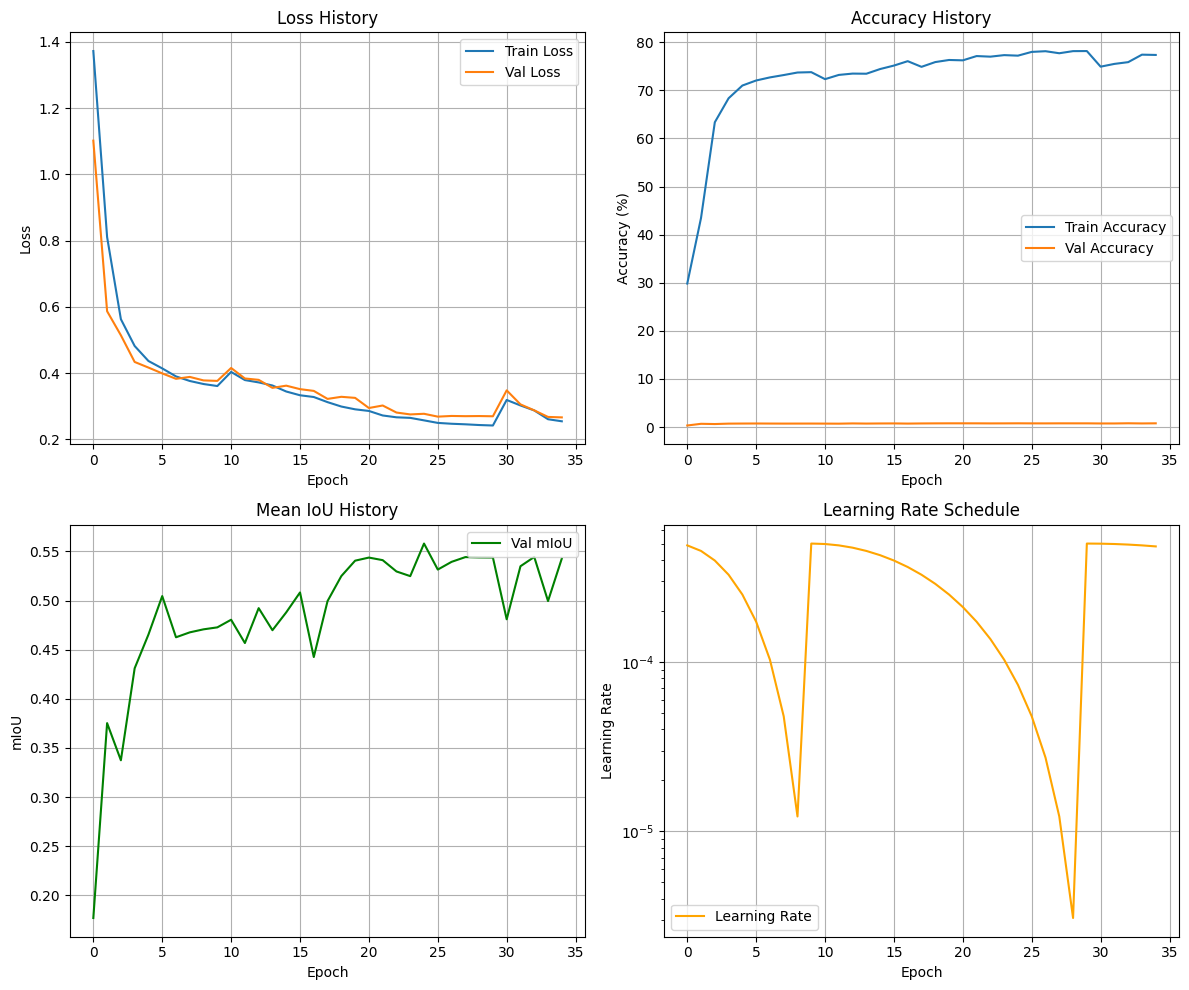

Training history plots generated and saved!


In [8]:
# 绘制训练历史
plot_training_history(history, save_path=f"{config['save_dir']}/training_curves.png")

# 保存训练历史
with open(f"{config['save_dir']}/history.json", 'w') as f:
    json.dump(history, f, indent=4)

print("Training history plots generated and saved!")

## 9. 模型评估

In [9]:
# 加载最佳模型
import torch
try:
    # 尝试使用weights_only=False（PyTorch 2.6+）
    checkpoint = torch.load(f"{config['save_dir']}/best_model.pth", map_location=device, weights_only=False)
except TypeError:
    # 如果不支持weights_only参数，使用旧版本语法
    checkpoint = torch.load(f"{config['save_dir']}/best_model.pth", map_location=device)

model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print(f"Loaded best model (epoch {checkpoint['epoch']}, mIoU: {checkpoint['best_miou']:.4f})")

# 在测试集上评估
test_loss, test_acc, test_metrics = validate(
    model, test_loader, criterion, device, data_info['num_classes']
)

print(f"\nTest Results:")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.2f}%")
print(f"Test mIoU: {test_metrics['mean_iou']:.4f}")
print(f"Mean Class Accuracy: {test_metrics['mean_accuracy']:.4f}")

# 详细的每类指标 - 修正索引方式
print(f"\nPer-class metrics:")
class_labels = sorted(data_info['class_names'].keys())
for idx, class_label in enumerate(class_labels):
    class_name = data_info['class_names'][class_label]
    if idx < len(test_metrics['per_class_accuracy']):
        acc = test_metrics['per_class_accuracy'][idx]
        iou = test_metrics['per_class_iou'][idx]
        print(f"  {class_name}: Acc={acc:.3f}, IoU={iou:.3f}")

Loaded best model (epoch 25, mIoU: 0.5579)


Validation:   0%|          | 0/14 [00:00<?, ?it/s]


Test Results:
Test Loss: 0.2210
Test Accuracy: 0.82%
Test mIoU: 0.5755
Mean Class Accuracy: 0.8031

Per-class metrics:
  Corn: Acc=0.843, IoU=0.818
  Wheat: Acc=0.961, IoU=0.523
  Sunflower: Acc=0.829, IoU=0.678
  Pumpkin: Acc=0.965, IoU=0.450
  Artificial_Surface: Acc=0.724, IoU=0.463
  Water: Acc=0.964, IoU=0.868
  Road: Acc=0.772, IoU=0.515
  Other: Acc=0.366, IoU=0.288


## 10. 评估结果可视化

findfont: Generic family 'sans-serif' not found because none of the following families were found: PingFang SC, SimHei, Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: PingFang SC, SimHei, Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: PingFang SC, SimHei, Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: PingFang SC, SimHei, Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: PingFang SC, SimHei, Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: PingFang SC, SimHei, Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: PingFang SC, SimHei, Arial Unicode MS
findfont: Generic family 'sans-serif' not

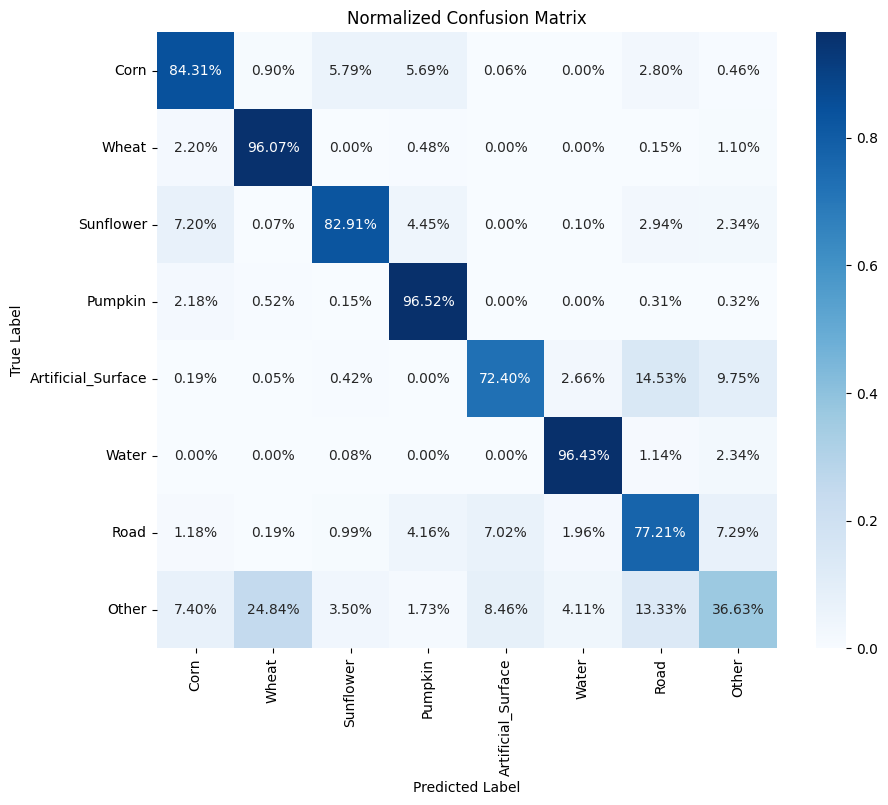

findfont: Generic family 'sans-serif' not found because none of the following families were found: PingFang SC, SimHei, Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: PingFang SC, SimHei, Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: PingFang SC, SimHei, Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: PingFang SC, SimHei, Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: PingFang SC, SimHei, Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: PingFang SC, SimHei, Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: PingFang SC, SimHei, Arial Unicode MS
findfont: Generic family 'sans-serif' not

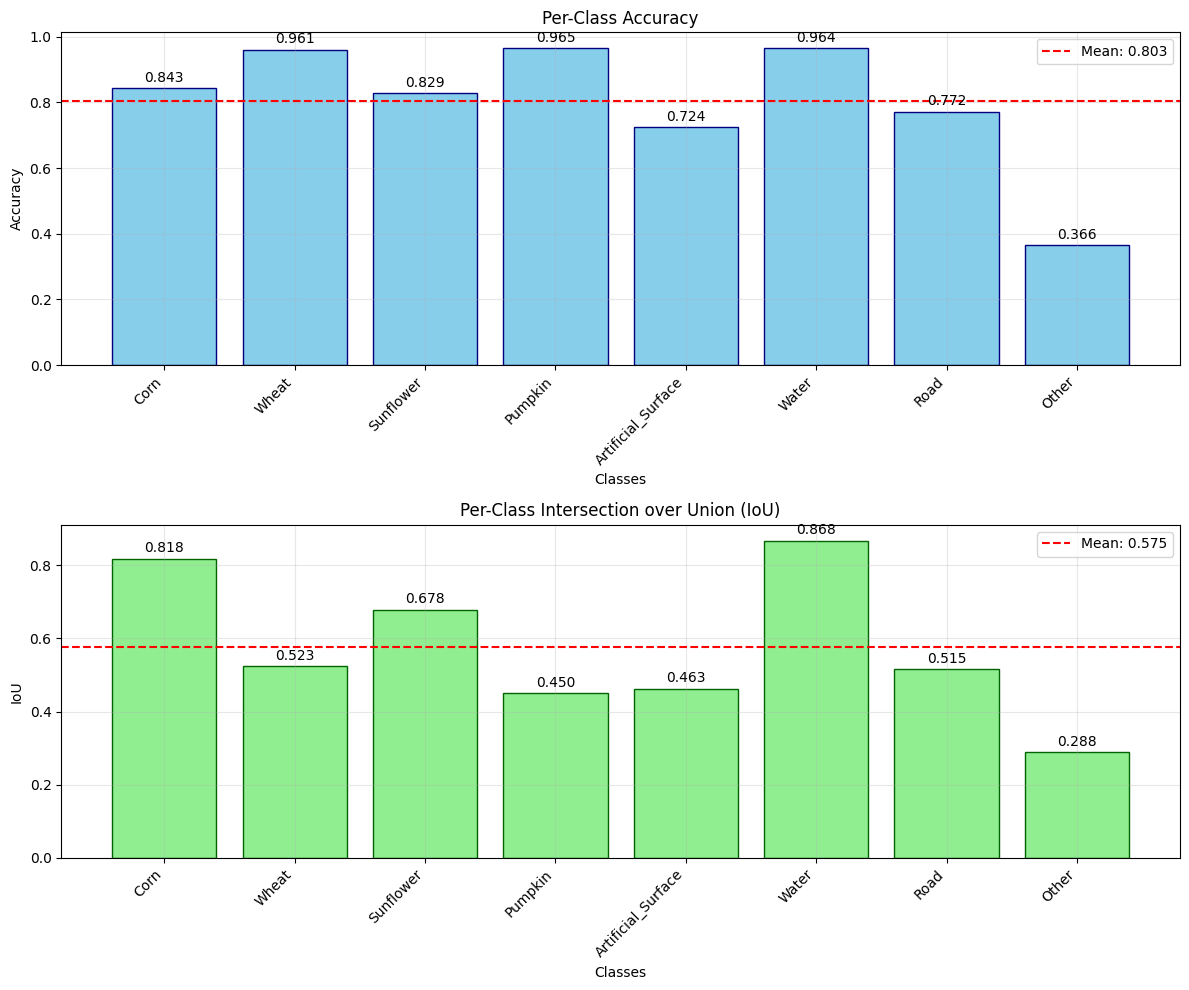

In [10]:
# 绘制混淆矩阵
# 修正类别名称列表的生成方式，使用实际的类别标签键
class_names_list = [data_info['class_names'][i] for i in sorted(data_info['class_names'].keys())]
plot_confusion_matrix(
    test_metrics['confusion_matrix'],
    class_names_list,
    save_path=f"{config['save_dir']}/confusion_matrix.png"
)

# 绘制类别性能图 - 需要先添加class_names到metrics中
test_metrics_with_names = test_metrics.copy()
test_metrics_with_names['class_names'] = {i: name for i, name in data_info['class_names'].items()}

plot_class_performance(
    test_metrics_with_names, 
    save_path=f"{config['save_dir']}/class_performance.png"
)

## 11. 预测样本可视化

findfont: Generic family 'sans-serif' not found because none of the following families were found: PingFang SC, SimHei, Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: PingFang SC, SimHei, Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: PingFang SC, SimHei, Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: PingFang SC, SimHei, Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: PingFang SC, SimHei, Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: PingFang SC, SimHei, Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: PingFang SC, SimHei, Arial Unicode MS
findfont: Generic family 'sans-serif' not

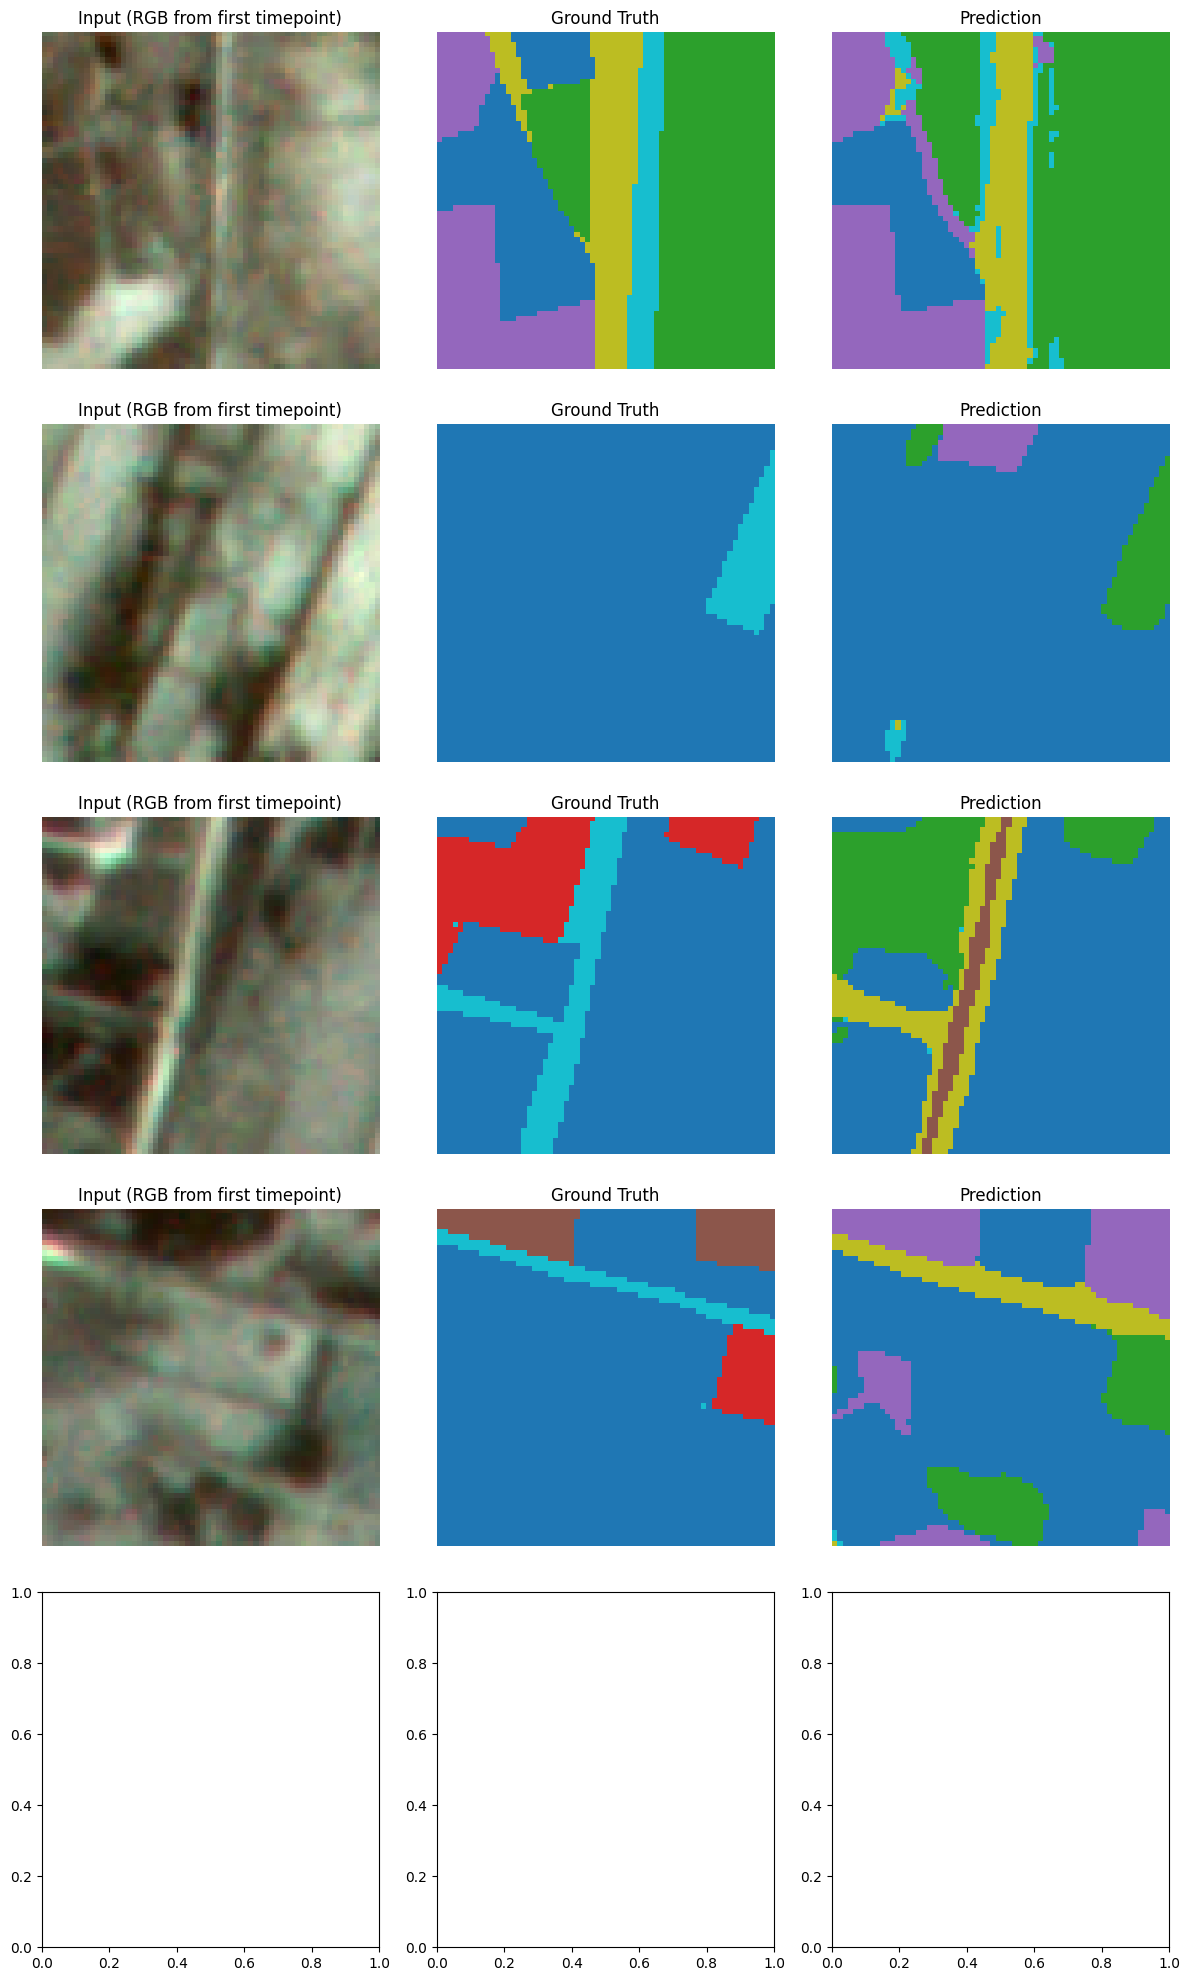

In [11]:
from TCN.utils import visualize_predictions

# 获取一批测试数据
data_iter = iter(test_loader)
test_batch_data, test_batch_targets = next(data_iter)

# 预测
model.eval()
with torch.no_grad():
    test_batch_data_device = test_batch_data.to(device)
    test_outputs = model(test_batch_data_device)
    _, test_predictions = test_outputs.max(-1)

# 可视化前5个样本的预测结果
visualize_predictions(
    test_batch_data[:5],
    test_batch_targets[:5],
    test_predictions[:5].cpu(),
    class_names_list,
    num_samples=5,
    save_path=f"{config['save_dir']}/predictions_visualization.png"
)

## 12. 模型推理示例

In [18]:
from TCN.inference import CropMappingInference

# 初始化推理器
inferencer = CropMappingInference(
    model_path=f"{config['save_dir']}/best_model.pth",
    device=config['device']
)

# 使用与数据加载相同的路径逻辑
dataset_path = config['data_path']  # 使用之前确定的正确路径
full_x_data = np.load(os.path.join(dataset_path, 'x.npy'))
full_y_data = np.load(os.path.join(dataset_path, 'y.npy'))

# 选择一个较小的区域进行快速推理演示
crop_size = 128
x_crop = full_x_data[:crop_size, :crop_size]
y_crop = full_y_data[:crop_size, :crop_size]

print(f"Running inference on {x_crop.shape[:2]} region...")

# 进行推理
predictions = inferencer.predict_full_image(
    x_crop,
    patch_size=32,  # 使用较小的patch以加快推理
    overlap=8,
    batch_size=4
)

# 修正类别名称列表
class_names_list = [data_info['class_names'][i] for i in sorted(data_info['class_names'].keys())]

# 可视化推理结果
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 显示RGB合成图（使用第一个时间步的前三个波段）
rgb = x_crop[:, :, 0, :3]
rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min())
axes[0].imshow(rgb)
axes[0].set_title('Input (RGB Composite)')
axes[0].axis('off')

# 显示真实标签
im1 = axes[1].imshow(y_crop, cmap='tab10', vmin=1, vmax=8)
axes[1].set_title('Ground Truth')
axes[1].axis('off')

# 显示预测结果
axes[2].imshow(predictions, cmap='tab10', vmin=1, vmax=8)
axes[2].set_title('TCN Predictions')
axes[2].axis('off')

# 添加颜色条
cbar = plt.colorbar(im1, ax=axes, orientation='horizontal', fraction=0.05, pad=0.1)
# 修正颜色条刻度
cbar.set_ticks(sorted(data_info['class_names'].keys()))
cbar.set_ticklabels(class_names_list)

plt.tight_layout()
plt.savefig(f"{config['save_dir']}/inference_example.png", dpi=300, bbox_inches='tight')
plt.show()

# 计算推理准确率
inference_acc = np.mean(predictions == y_crop)
print(f"\nInference accuracy on cropped region: {inference_acc:.4f}")

# 统计预测分布
unique, counts = np.unique(predictions, return_counts=True)
print("\nPrediction distribution:")
for label, count in zip(unique, counts):
    percentage = count / predictions.size * 100
    class_name = data_info['class_names'].get(label, f"Unknown({label})")
    print(f"  {class_name}: {count:,} pixels ({percentage:.1f}%)")

RuntimeError: Error(s) in loading state_dict for CropMappingTCN:
	size mismatch for tcn.network.0.conv1.conv.weight: copying a param with shape torch.Size([96, 8, 5]) from checkpoint, the shape in current model is torch.Size([96, 8, 3]).
	size mismatch for tcn.network.0.conv2.conv.weight: copying a param with shape torch.Size([96, 96, 5]) from checkpoint, the shape in current model is torch.Size([96, 96, 3]).
	size mismatch for tcn.network.1.conv1.conv.weight: copying a param with shape torch.Size([192, 96, 5]) from checkpoint, the shape in current model is torch.Size([192, 96, 3]).
	size mismatch for tcn.network.1.conv2.conv.weight: copying a param with shape torch.Size([192, 192, 5]) from checkpoint, the shape in current model is torch.Size([192, 192, 3]).
	size mismatch for tcn.network.2.conv1.conv.weight: copying a param with shape torch.Size([384, 192, 5]) from checkpoint, the shape in current model is torch.Size([384, 192, 3]).
	size mismatch for tcn.network.2.conv2.conv.weight: copying a param with shape torch.Size([384, 384, 5]) from checkpoint, the shape in current model is torch.Size([384, 384, 3]).

## 13. 总结与结论

In [16]:
# 生成最终总结报告
summary_report = f"""
=== TCN模型训练总结报告 ===
训练时间: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
设备: {device}

模型配置:
- 输入通道数: {config['input_channels']}
- 时间步数: {config['temporal_steps']}
- TCN通道: {config['tcn_channels']}
- 类别数: {data_info['num_classes']}
- 总参数量: {total_params:,}

训练配置:
- 训练轮数: {len(history['train_loss'])}
- 批次大小: {config['batch_size']}
- 学习率: {config['learning_rate']}
- 切片大小: {config['patch_size']}

最佳性能 (验证集):
- mIoU: {best_miou:.4f}
- 准确率: {max(history['val_acc']):.2f}%

测试集性能:
- mIoU: {test_metrics['mean_iou']:.4f}
- 总体准确率: {test_metrics['overall_accuracy']:.4f}
- 平均类别准确率: {test_metrics['mean_accuracy']:.4f}

文件输出:
- 最佳模型: {config['save_dir']}/best_model.pth
- 训练历史: {config['save_dir']}/history.json
- 数据信息: {config['save_dir']}/data_info.pkl
- 训练曲线: {config['save_dir']}/training_curves.png
- 混淆矩阵: {config['save_dir']}/confusion_matrix.png

=== 报告结束 ===
"""

print(summary_report)

# 保存报告
with open(f"{config['save_dir']}/training_summary.txt", 'w', encoding='utf-8') as f:
    f.write(summary_report)

print(f"\n🎯 训练完成！所有结果已保存到: {config['save_dir']}/")
print(f"📊 最佳模型mIoU: {best_miou:.4f}")
print(f"📈 测试集mIoU: {test_metrics['mean_iou']:.4f}")


=== TCN模型训练总结报告 ===
训练时间: 2025-07-29 19:44:43
设备: cuda

模型配置:
- 输入通道数: 8
- 时间步数: 28
- TCN通道: [96, 192, 384]
- 类别数: 8
- 总参数量: 1,577,576

训练配置:
- 训练轮数: 35
- 批次大小: 4
- 学习率: 0.0005
- 切片大小: 64

最佳性能 (验证集):
- mIoU: 0.5579
- 准确率: 0.79%

测试集性能:
- mIoU: 0.5755
- 总体准确率: 0.8211
- 平均类别准确率: 0.8031

文件输出:
- 最佳模型: ./checkpoints_train/best_model.pth
- 训练历史: ./checkpoints_train/history.json
- 数据信息: ./checkpoints_train/data_info.pkl
- 训练曲线: ./checkpoints_train/training_curves.png
- 混淆矩阵: ./checkpoints_train/confusion_matrix.png

=== 报告结束 ===


🎯 训练完成！所有结果已保存到: ./checkpoints_train/
📊 最佳模型mIoU: 0.5579
📈 测试集mIoU: 0.5755
